In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2  
import math
import glob

In [2]:
def show_images(images, cmap=None):
    cols = 2
    rows = (len(images)+1)//cols
    
    plt.figure(figsize=(20, 22))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        # use gray scale color map if there is only one channel
        cmap = 'gray' if len(image.shape)==2 else cmap
        plt.imshow(image, cmap=cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()


In [3]:
test_images = [plt.imread(path) for path in glob.glob('new_road_images/*.jpg')]

In [60]:
def region_of_interest(img, vertices):
    mask = np.zeros_like(img)
    match_mask_color = 255
    cv2.fillPoly(mask, vertices, match_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [5]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=3):
    if lines is None:
        return
    img = np.copy(img)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(line_img, (x1, y1), (x2, y2), color, thickness)
    img = cv2.addWeighted(img, 0.8, line_img, 1.0, 0.0)
    distancex1 = x2 - x1
    distancex2 = x2 - y1
    distancey1 = y2 - y1
    distancey2 = y2 - x1
    cv2.line(line_img,  (distancex1, distancex2), (distancey1, distancey2), color, thickness)
    return img 

In [13]:
def make_line_points(y1, y2, line):
    """
    Convert a line represented in slope and intercept into pixel points
    """
    if line is None:
        return None
    
    slope, intercept = line
    
    # make sure everything is integer as cv2.line requires it
    x1 = int((y1 - intercept)/slope)
    x2 = int((y2 - intercept)/slope)
    y1 = int(y1)
    y2 = int(y2)
    
    return ((x1, y1), (x2, y2))

In [14]:
def average_slope_intercept(lines):
    left_lines    = [] # (slope, intercept)
    left_weights  = [] # (length,)
    right_lines   = [] # (slope, intercept)
    right_weights = [] # (length,)
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            if x2==x1:
                continue # ignore a vertical line
            slope = (y2-y1)/(x2-x1)
            intercept = y1 - slope*x1
            length = np.sqrt((y2-y1)**2+(x2-x1)**2)
            if slope < 0: # y is reversed in image
                left_lines.append((slope, intercept))
                left_weights.append((length))
            else:
                right_lines.append((slope, intercept))
                right_weights.append((length))
    
    # add more weight to longer lines    
    left_lane  = np.dot(left_weights,  left_lines) /np.sum(left_weights)  if len(left_weights) >0 else None
    right_lane = np.dot(right_weights, right_lines)/np.sum(right_weights) if len(right_weights)>0 else None
    
    return left_lane, right_lane # (slope, intercept), (slope, intercept)


In [15]:
def lane_lines(image, lines):
    left_lane, right_lane = average_slope_intercept(lines)
    
    y1 = image.shape[0] # bottom of the image
    y2 = y1*0.6         # slightly lower than the middle

    left_line  = make_line_points(y1, y2, left_lane)
    right_line = make_line_points(y1, y2, right_lane)
    
    return left_line, right_line

In [16]:
def draw_lane_lines(image, lines, color=[255, 0, 0], thickness=20):
    # make a separate image to draw lines and combine with the orignal later
    line_image = np.zeros_like(image)
    for line in lines:
        if line is not None:
            cv2.line(line_image, *line,  color, thickness)
    # image1 * α + image2 * β + λ
    # image1 and image2 must be the same shape.
    return cv2.addWeighted(image, 1.0, line_image, 0.95, 0.0)

In [37]:
def convert_hls(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2HLS)

def select_white_yellow(image):
    converted = convert_hls(image)
    # white color mask
    lower = np.uint8([  0, 200,   0])
    upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(converted, lower, upper)
    # yellow color mask
    lower = np.uint8([ 10,   0, 100])
    upper = np.uint8([ 40, 255, 255])
    yellow_mask = cv2.inRange(converted, lower, upper)
    # combine the mask
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    return cv2.bitwise_and(image, image, mask = mask)

(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)


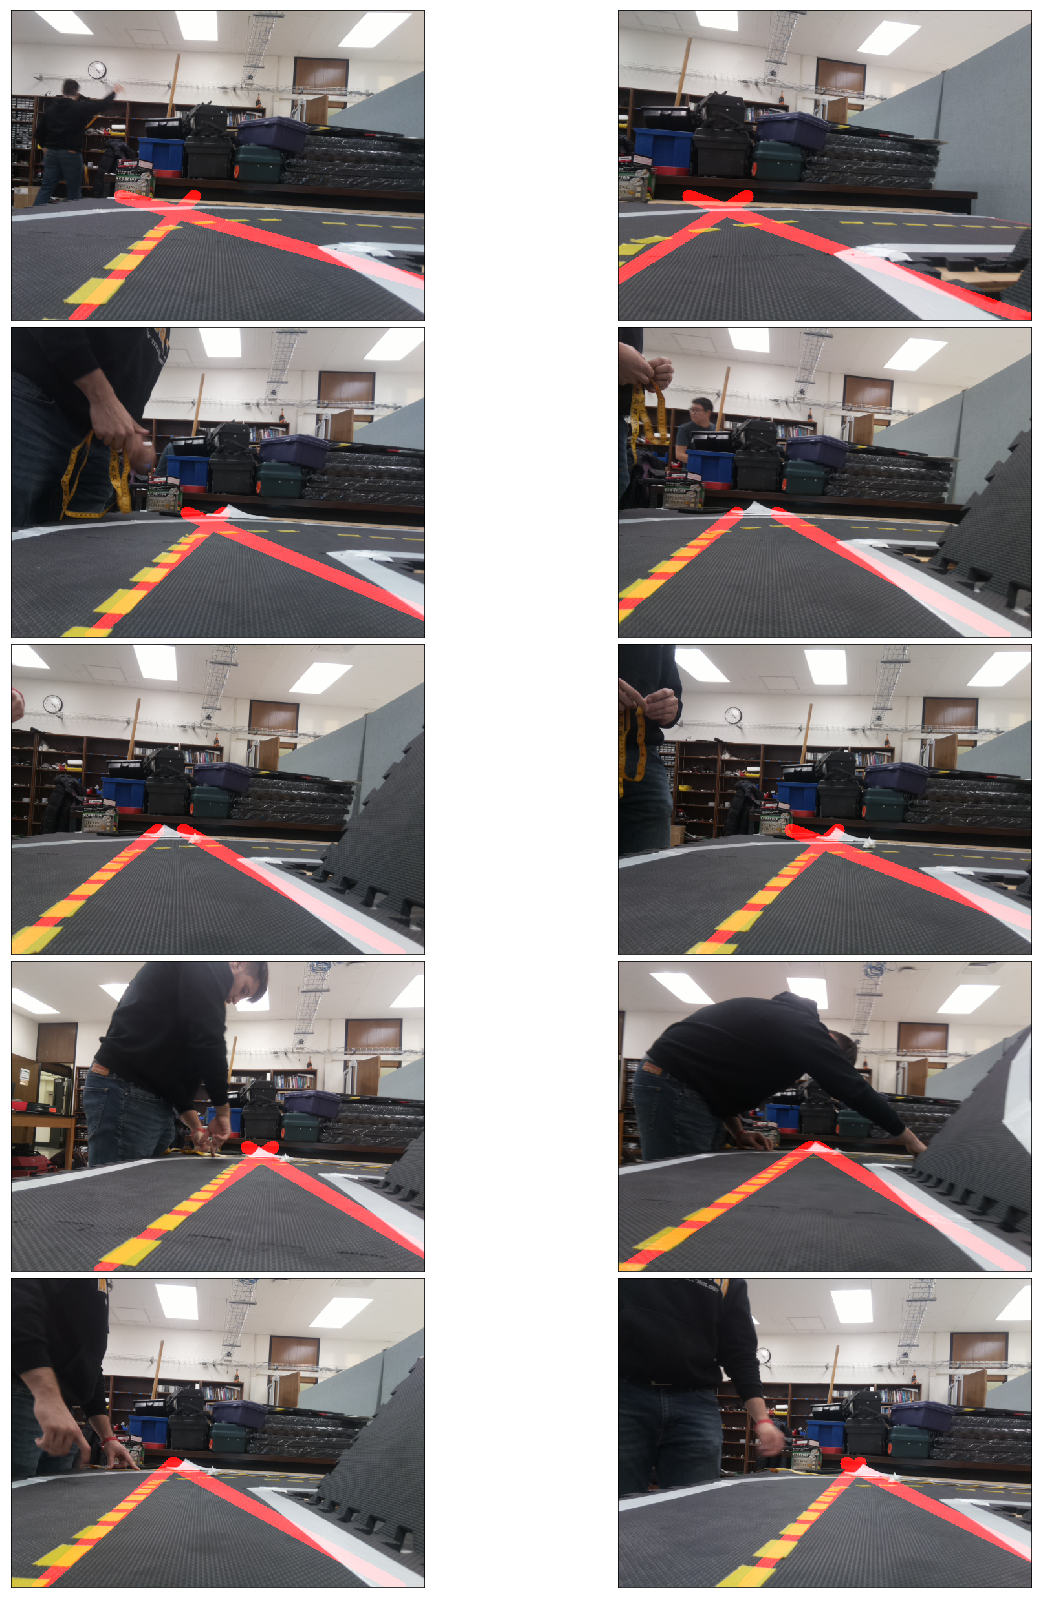

In [59]:
lined_images = []
for image in test_images:
    height, width, temp = image.shape
    region_of_interest_vert = [(0, height), (0, 360), (width, 360), (width, height)]
    white_yellow_image = select_white_yellow(image)
    gray_img = cv2.cvtColor(white_yellow_image, cv2.COLOR_RGB2GRAY)
    cannyed_img = cv2.Canny(gray_img, 200, 300)
    cropped_img = region_of_interest(cannyed_img, np.array([region_of_interest_vert], np.int32))
#     lines = cv2.HoughLinesP(cropped_img, rho=6, theta=np.pi/60, threshold=160,
#         lines=np.array([]), minLineLength=40, maxLineGap=25)
    
    lines = cv2.HoughLinesP(cropped_img, rho=1, theta=np.pi/60, threshold=10, minLineLength=40, maxLineGap=25)
    
    left_line, right_line = lane_lines(image, lines)
    line_image = draw_lane_lines(image, (left_line, right_line))
    lined_images.append(line_image)
    
show_images(lined_images)


##### 